In [298]:
from sklearn.cluster import DBSCAN
from shapely.geometry import MultiPoint,Point,Polygon
import pandas as pd
import geopandas as gp
from shapely import wkt
import numpy as np
import matplotlib.pyplot as plt

In [299]:
us_counties = gp.read_file(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\GeoData\US_County_Boundaries\US_CountyBndrys.shp')
us_counties = us_counties.to_crs("EPSG:4326")

Try DBscan for Colorado
1. Read Colorado data
2. Split point data into lat and long county wise

In [300]:
df = pd.read_csv(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Industrial\co_location_data.csv')
df.head()
location = df.location.apply(wkt.loads)
location = gp.GeoSeries(location)
location = location.set_crs("EPSG:3857")
location = location.to_crs("EPSG:4326")

df['lon'] = location.x
df['lat'] = location.y

df.head()

,Unnamed: 0,naics,state,county,location,employee count,capacity_fraction,water demand (m3/yr),lon,lat
0,61,311,CO,Routt County,POINT (-11893125.8421943 4936961.89510179),25.0,0.000017,26297.372624,-106.837767,40.486970
1,62,339,CO,Routt County,POINT (-11894028.3760979 4937373.58847611),15.0,0.000023,330.404147,-106.845875,40.489783
2,63,332,CO,Moffat County,POINT (-11975236.1450066 4940352.26725026),20.0,0.000013,1321.261702,-107.575377,40.510130
3,64,336,CO,Routt County,POINT (-11895028.5483268 4939807.6845928),29.0,0.000020,2609.412582,-106.854860,40.506411
4,21282,332,CO,Mesa County,POINT (-12093585.2167406 4737756.37094809),30.0,0.000020,1981.892552,-108.638524,39.112202


Function to find clusters and calculate their centroid

In [301]:
centroids = []

for county in df.county.unique():
    df1 = df[df['county']==county]
    coords = df1[['lat', 'lon']].to_numpy()

    # define the number of kilometers in one radian
    kms_per_radian = 6371.0088
    epsilon = 10/ kms_per_radian

    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_

    # get the number of clusters
    num_clusters = len(set(cluster_labels))

    # turn the clusters in to a pandas series, where each element is a cluster of points
    clusters = pd.Series((coords[cluster_labels==n] for n in range(num_clusters)))

    for ea in clusters:
        centroids.append((MultiPoint(ea).centroid.x, MultiPoint(ea).centroid.y))

centroids = np.array(centroids)



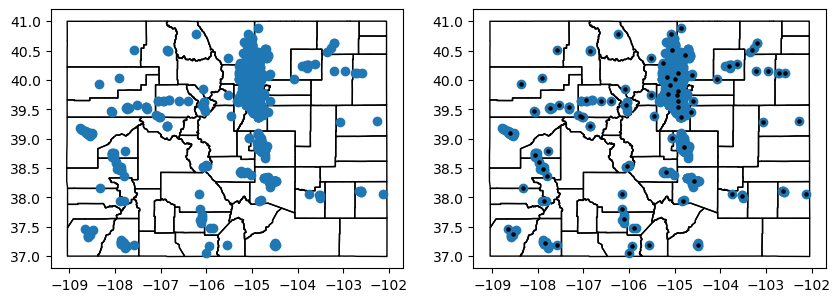

In [304]:
state_code = '08'
state = us_counties.loc[us_counties['STATEFP']==state_code]

fig, (ax0,ax) = plt.subplots(1,2,figsize=(10,5))

# All places

state.plot(ax=ax,figsize=(50, 50),facecolor ='none',edgecolor ='black')
industry_loc = gp.GeoSeries(df.location.apply(wkt.loads))
industry_loc = industry_loc.set_crs("EPSG:3857")
industry_loc = industry_loc.to_crs("EPSG:4326")
industry_loc.plot(ax=ax)

state.plot(ax=ax0,figsize=(50, 50),facecolor ='none',edgecolor ='black')
industry_loc.plot(ax=ax0)

# centroids.plot(ax=ax)
ax.scatter(centroids[:,1],centroids[:,0],s=5,color='black')